# <font color='navy'>**1. Document Classification**
Allison Aprile

Assignment 4

April 30, 2021

In [1]:
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('punkt')
from google.colab import drive
from nltk import word_tokenize, sent_tokenize, pad_sequence
import sys
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Input, Embedding, Conv1D, Flatten, MaxPool1D, Dense, LSTM, Bidirectional, Concatenate
from keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <font color='navy'>**(a) Preprocess the data**

In [4]:
''' 
Processes Project Gutenberg text files:
    - Discard text other than book text
    - Split into samples (paragraphs)
    - Remove short sentences/chapter headers
    - Replace newlines and other characters
    - Normalize (lowercasing all text)
    - Tokenize

Returns:
    - samples: list cleaned paragraphs
    - tokens: list of tokenized paragraphs
'''
def process_text(txt):
  # Open file
  with open(txt) as f:
    # Read as string
    text = f.read()

    # Keep only book text
    filtered_text = text[text.find('***START OF THE PROJECT GUTENBERG EBOOK'):text.find('***END OF THE PROJECT GUTENBERG EBOOK')]

    if len(filtered_text) == 0:
      filtered_text = text[text.find('*** START OF THIS PROJECT GUTENBERG EBOOK'):text.find('*** END OF THIS PROJECT GUTENBERG EBOOK')]

    # Split text into paragraphs 
    data = filtered_text.split('\n\n') # Use double newline because of text file formatting

    # Remove sentences with less than 10 words - gets rid of chapter/book headings and blank lines
    data = [d for d in data if len(d.strip().split(' ')) >= 10]

    # Replace any '\n' characters (for formatting) and normalize
    data = [d.replace('\n', ' ').lower() for d in data]

    # Remove any sentences with 'chapter'
    data = [d for d in data if 'chapter' not in d]

    # Tokenize sentences
    tokens = [word_tokenize(d) for d in data]

    # Remove any non-alphanumeric tokens (including punctuation)
    tokens = [[t for t in toks if t.isalpha() and len(t) > 1] for toks in tokens]

    # Join for individual training texts
    samples = [' '.join(lst) for lst in tokens]

    return samples, tokens

In [5]:
# Choose texts
books = {'28054-0.txt' : 'dostoyevsky', 'pg1661.txt' : 'doyle', 'pg31100.txt': 'austen'}

In [6]:
# Define lists for each set of data (80% training, 10% validation, 10% testing)
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

# Iterate through each of the texts and add to data subsets
for b in books.keys():
  # Get samples (paragraphs) and tokenized sentences
  samples, tokens = process_text('/content/drive/My Drive/a4-data/q1/' + b)

  # Allocate tokens to training, validation, and testing lists
  x_train, x_test, train_y, test_y = train_test_split(samples, [books[b]]*len(samples), test_size=0.2, train_size=0.8)
  x_val, x_test, val_y, test_y = train_test_split(x_test, test_y, test_size=0.5, train_size=0.5)

  X_train += x_train
  y_train += train_y
  X_val += x_val
  y_val += val_y
  X_test += x_test
  y_test += test_y


In [7]:
# Create vocabulary from training dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocabulary = tokenizer.word_index

# Integer encode all datasets
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_val_encoded = tokenizer.texts_to_sequences(X_val)

# Pad all datasets to length 50
X_train_encoded = pad_sequences(X_train_encoded, maxlen=50, padding='post')
X_test_encoded = pad_sequences(X_test_encoded, maxlen=50, padding='post')
X_val_encoded = pad_sequences(X_val_encoded, maxlen=50, padding='post')

In [8]:
# One-hot encode label vectors
ohe = OneHotEncoder(sparse=False)
y_train_encoded = ohe.fit_transform(np.array(y_train).reshape(-1,1))
y_test_encoded = ohe.fit_transform(np.array(y_test).reshape(-1,1))
y_val_encoded = ohe.fit_transform(np.array(y_val).reshape(-1,1))

In [10]:
# Confirm shapes
print(len(X_train))
print(X_train_encoded.shape)
print(len(y_train))
print(y_train_encoded.shape)
print()

print(len(X_val))
print(X_val_encoded.shape)
print(len(y_val))
print(y_val_encoded.shape)
print()

print(len(X_test))
print(X_test_encoded.shape)
print(len(y_test)) 
print(y_test_encoded.shape)

12774
(12774, 50)
12774
(12774, 3)

1597
(1597, 50)
1597
(1597, 3)

1598
(1598, 50)
1598
(1598, 3)


In [11]:
# Create dictionary for later predictions
# Check indices
print(y_test_encoded[0])
print(y_test[0])

# Map indices to authors
pred_mapping = {0: 'austen', 1: 'dostoyevsky', 2: 'doyle'}

[0. 1. 0.]
dostoyevsky


In [12]:
# Load GLoVe for text embeddings
# Open GloVe values downloaded from https://nlp.stanford.edu/projects/glove/
fi = open('/content/drive/My Drive/a4-data/glove.6B.50d.txt', 'r')

# Initialize embedding dictionary
glove = {}

# Record each word as a key and its embedding vector as a value in glove dictionary
for li in fi:
  # Split into word and each embedding value
  line = li.split()

  # Take first element as word
  word = line[0]

  # Take remaining elements as embedding values
  value = np.array([float(val) for val in line[1:]])

  # Add word to dictionary
  glove[word] = value

# Close file
fi.close()

In [13]:
# Initialize word vectors using pre-trained Glove embeddings
def embed_text(glove_dict, vocabulary):
  # Get list of all GLoVe keys
  glove_keys = list(glove_dict.keys())

  # Initialize word embedding matrix with zeros
  word_embeddings = np.zeros((len(vocabulary) + 1, 50))

  # Update word embeddings by mapping each vocabulary word
  # to its corresponding GLoVe vector
  for key, value in vocabulary.items():
    # For names and uncommon words
    if key not in glove_keys:
      # Map to unk value
      word_vec = glove_dict['unk']
    
    # For common words (words covered by GLoVe)
    else:
      word_vec = glove_dict['key']

    # Update word_embeddings
    word_embeddings[value] = word_vec

  return word_embeddings

In [15]:
# Initialize word vectors using GLoVe
word_embeddings = embed_text(glove, vocabulary)

# Confirm
print(word_embeddings.shape)

(18891, 50)


# <font color='navy'>**(b) Build models (Implement forward pass)**

## **CNN**

In [98]:
# Define Sequential model as base 
cnn = Sequential()

# Initialize Embedding layer with GLoVe embeddings
cnn.add(Embedding(len(vocabulary) + 1, 50, weights = [word_embeddings],
                    input_length = 50, trainable = True))

# Add Convolutional block - padding = 'same' zero pads input matrix
cnn.add(Conv1D(128, 3, activation='relu', input_shape=(50,), padding='same'))
cnn.add(MaxPool1D(2,2))

# Flatten
cnn.add(Flatten())

# Add MLP for output 
cnn.add(Dense(100, activation='relu')) # Additional hidden layer
cnn.add(Dense(3, activation='softmax')) # Output layer

In [99]:
# Print summary
cnn.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 50)            944550    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 128)           19328     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               320100    
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 303       
Total params: 1,284,281
Trainable params: 1,284,281
Non-trainable params: 0
___________________________________________

### **LSTM 1 - Max Valued Hidden States as Context Vector**

In [48]:
# Define Sequential model as base 
lstm_1 = Sequential()

# Initialize Embedding layer with GLoVe embeddings
lstm_1.add(Embedding(len(vocabulary) + 1, 50, weights = [word_embeddings],
                    input_length = 50, trainable = True))

# LSTM layer with Bidirectional wrapper - return_sequences = True to output all hidden states
lstm_1.add(Bidirectional(LSTM(64, activation='tanh', input_shape=(50,), return_sequences=True)))

# Take element-wise maximum of all hidden states
lstm_1.add(MaxPool1D())

# Flatten
lstm_1.add(Flatten())

# Dense prediction layer
lstm_1.add(Dense(3, activation='softmax'))

In [49]:
# Print summary
lstm_1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 50)            944550    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 128)           58880     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 9603      
Total params: 1,013,033
Trainable params: 1,013,033
Non-trainable params: 0
_________________________________________________________________


### **LSTM 2 - Last Hidden State as Context Vector**

In [50]:
# Define Sequential model as base 
lstm_2 = Sequential()

# Initialize Embedding layer with GLoVe embeddings
lstm_2.add(Embedding(len(vocabulary) + 1, 50, weights = [word_embeddings],
                    input_length = 50, trainable = True))

# LSTM layer with Bidirectional wrapper - return_sequences = False to output only last hidden state
lstm_2.add(Bidirectional(LSTM(64, activation='tanh', input_shape=(50,), return_sequences=False)))

# Dense prediction layer
lstm_2.add(Dense(3, activation='softmax'))

In [51]:
# Print summary
lstm_2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 50)            944550    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 387       
Total params: 1,003,817
Trainable params: 1,003,817
Non-trainable params: 0
_________________________________________________________________


# <font color='navy'>**(c) Backpropagation**

In [100]:
# Compile all models with Adam optimizer and 1e-3 learning rate
cnn.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
lstm_1.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
lstm_2.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
# Calculate the initial training categorical cross entropy losses of the models
print('CNN Initial Loss: ', cnn.evaluate(X_train_encoded, y_train_encoded)[0])
print()

print('LSTM (All Hidden Layers) Initial Loss: ', lstm_1.evaluate(X_train_encoded, y_train_encoded)[0])
print()

print('LSTM (Last Hidden Layer) Initial Loss: ', lstm_2.evaluate(X_train_encoded, y_train_encoded)[0])

400/400 [==============================] - 2s 4ms/step - loss: 1.2699 - accuracy: 0.2299
CNN Initial Loss:  1.0133424997329712

400/400 [==============================] - 7s 14ms/step - loss: 1.1844 - accuracy: 0.2304
LSTM (All Hidden Layers) Initial Loss:  0.9981018900871277

400/400 [==============================] - 7s 13ms/step - loss: 1.0615 - accuracy: 0.5016
LSTM (Last Hidden Layer) Initial Loss:  1.0109888315200806



# <font color='navy'>**(d) Train Models**

### **CNN**

In [101]:
# Fit model on training data for 5 epochs
cnn_history = cnn.fit(X_train_encoded, y_train_encoded, epochs=5, batch_size=64,
                      validation_data=(X_val_encoded, y_val_encoded))

Epoch 1/5
200/200 [==============================] - 9s 42ms/step - loss: 0.9112 - accuracy: 0.6152 - val_loss: 0.6903 - val_accuracy: 0.7627
Epoch 2/5
200/200 [==============================] - 8s 41ms/step - loss: 0.5077 - accuracy: 0.8006 - val_loss: 0.3100 - val_accuracy: 0.8760
Epoch 3/5
200/200 [==============================] - 8s 42ms/step - loss: 0.2307 - accuracy: 0.9088 - val_loss: 0.2570 - val_accuracy: 0.8929
Epoch 4/5
200/200 [==============================] - 8s 41ms/step - loss: 0.1264 - accuracy: 0.9556 - val_loss: 0.2099 - val_accuracy: 0.9173
Epoch 5/5
200/200 [==============================] - 8s 41ms/step - loss: 0.0713 - accuracy: 0.9776 - val_loss: 0.2579 - val_accuracy: 0.8992


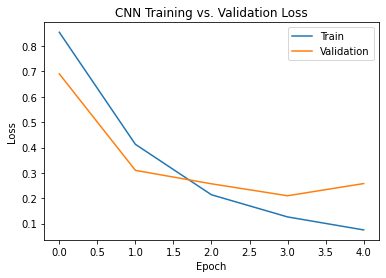

In [102]:
# Plot training and validation loss curves 
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

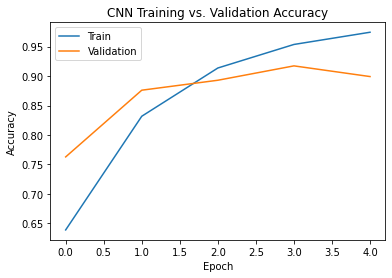

In [103]:
# Plot training and validation accuracy curves
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Training vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

For the CNN, I tried 32, 64, and 128 filters, as well as 10 and 100 neurons in the first MLP Dense layers. 128 filters performed significantly better than the other filter sizes, which only reached a maximum of 64% validation accuracy. In effort with unfreezing the Embedding layer parameters, the CNN was able to reach approximately 90% validation accuracy.

In [104]:
# Get testing predictions
cnn_pred = cnn.predict(X_test_encoded)

# Get index of maximum probability
cnn_pred = np.argmax(cnn_pred, axis=1)

# Map back to author names
cnn_pred = [pred_mapping[k] for k in cnn_pred]

In [105]:
# Report recall, precision, and F1 score
print(classification_report(y_test, cnn_pred))

              precision    recall  f1-score   support

      austen       0.98      0.91      0.95       949
 dostoyevsky       0.94      0.93      0.94       473
       doyle       0.60      0.85      0.71       176

    accuracy                           0.91      1598
   macro avg       0.84      0.90      0.86      1598
weighted avg       0.93      0.91      0.92      1598



### **LSTM 1 - Max Valued Hidden States as Context Vector**

In [59]:
# Fit model on training data for 5 epochs
lstm_1_history = lstm_1.fit(X_train_encoded, y_train_encoded, epochs=5, batch_size=64,
                      validation_data=(X_val_encoded, y_val_encoded))

Epoch 1/5
200/200 [==============================] - 21s 87ms/step - loss: 0.7302 - accuracy: 0.6882 - val_loss: 0.4405 - val_accuracy: 0.8197
Epoch 2/5
200/200 [==============================] - 18s 88ms/step - loss: 0.3237 - accuracy: 0.8680 - val_loss: 0.3419 - val_accuracy: 0.8560
Epoch 3/5
200/200 [==============================] - 17s 86ms/step - loss: 0.1778 - accuracy: 0.9317 - val_loss: 0.2368 - val_accuracy: 0.9067
Epoch 4/5
200/200 [==============================] - 17s 88ms/step - loss: 0.0960 - accuracy: 0.9652 - val_loss: 0.3867 - val_accuracy: 0.8873
Epoch 5/5
200/200 [==============================] - 17s 87ms/step - loss: 0.0617 - accuracy: 0.9785 - val_loss: 0.2840 - val_accuracy: 0.9205


For the LSTM, I first built a baseline with a hidden state size of 32. Using this, I observed that taking the element-wise maximum (versus average) of all the states after the Bidirectional LSTM layer yielded better performance. I also observed that unfreezing the Embedding lyaer parameters led to better performance. After that, I tried increasing and decreasing the hidden state size. The baseline validation accuracy was 91% after 10 epochs. I tried sizes of 16, 32, 64, and 128. Decreasing the hidden state size to 16 reduced performance by approximately 5%, and increasing it to 64 increased the performance by 2%. Further increasing it to 128 kept the validation performance around 93% (equivalent to 64), but significantly increased computational cost. Therefore, I decided on using a hidden state size of 64.

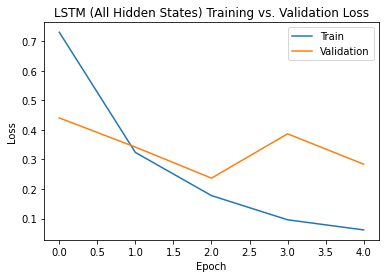

In [60]:
# Plot training and validation loss curves 
plt.plot(lstm_1_history.history['loss'])
plt.plot(lstm_1_history.history['val_loss'])
plt.title('LSTM (All Hidden States) Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

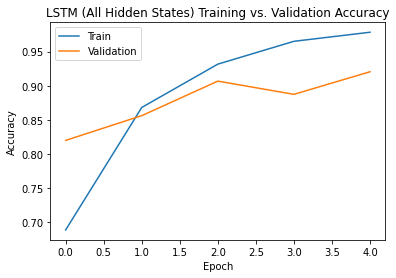

In [61]:
# Plot training and validation accuracy curves 
plt.plot(lstm_1_history.history['accuracy'])
plt.plot(lstm_1_history.history['val_accuracy'])
plt.title('LSTM (All Hidden States) Training vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [62]:
# Get testing predictions
lstm_1_pred = lstm_1.predict(X_test_encoded)

# Get index of maximum probability
lstm_1_pred = np.argmax(lstm_1_pred, axis=1)

# Map back to author names
lstm_1_pred = [pred_mapping[k] for k in lstm_1_pred]

In [63]:
# Report recall, precision, and F1 score
print(classification_report(y_test, lstm_1_pred))

              precision    recall  f1-score   support

      austen       0.94      0.99      0.96       949
 dostoyevsky       0.98      0.88      0.93       473
       doyle       0.78      0.77      0.77       176

    accuracy                           0.93      1598
   macro avg       0.90      0.88      0.89      1598
weighted avg       0.93      0.93      0.93      1598



### **LSTM 2 - Last Hidden State as Context Vector**

In [64]:
# Fit model on training data for 5 epochs
lstm_2_history = lstm_2.fit(X_train_encoded, y_train_encoded, epochs=5, batch_size=64,
                      validation_data=(X_val_encoded, y_val_encoded))

Epoch 1/5
200/200 [==============================] - 21s 85ms/step - loss: 0.7596 - accuracy: 0.6881 - val_loss: 0.4921 - val_accuracy: 0.8128
Epoch 2/5
200/200 [==============================] - 17s 87ms/step - loss: 0.3689 - accuracy: 0.8568 - val_loss: 0.3607 - val_accuracy: 0.8528
Epoch 3/5
200/200 [==============================] - 19s 97ms/step - loss: 0.2385 - accuracy: 0.9099 - val_loss: 0.2880 - val_accuracy: 0.8779
Epoch 4/5
200/200 [==============================] - 18s 91ms/step - loss: 0.1551 - accuracy: 0.9449 - val_loss: 0.2612 - val_accuracy: 0.9054
Epoch 5/5
200/200 [==============================] - 17s 86ms/step - loss: 0.1178 - accuracy: 0.9583 - val_loss: 0.2950 - val_accuracy: 0.9111


For this LSTM, I followed the same tuning protocol as with the first LSTM. I observed the same optimal parameters as well - using a hidden state size of 64 and unfreezing the Embedding layers. This is expected because the last hidden state contains information about all the inputs and previous states; it is essentially a summary of the prior hidden states. The overall performance itself is similar as well, although this LSTM trained faster and has a few thousand less parameters. 

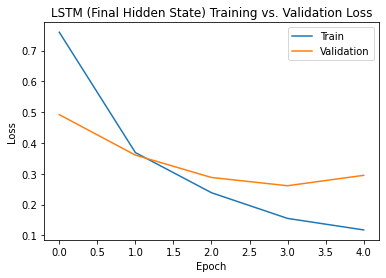

In [65]:
# Plot training and validation loss curves 
plt.plot(lstm_2_history.history['loss'])
plt.plot(lstm_2_history.history['val_loss'])
plt.title('LSTM (Final Hidden State) Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

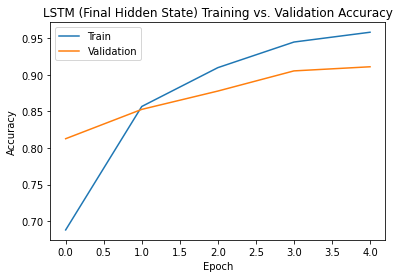

In [66]:
# Plot training and validation accuracy curves 
plt.plot(lstm_2_history.history['accuracy'])
plt.plot(lstm_2_history.history['val_accuracy'])
plt.title('LSTM (Final Hidden State) Training vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [67]:
# Get testing predictions
lstm_2_pred = lstm_2.predict(X_test_encoded)

# Get index of maximum probability
lstm_2_pred = np.argmax(lstm_2_pred, axis=1)

# Map back to author names
lstm_2_pred = [pred_mapping[k] for k in lstm_2_pred]

In [68]:
# Report recall, precision, and F1 score
print(classification_report(y_test, lstm_2_pred))

              precision    recall  f1-score   support

      austen       0.91      0.99      0.95       949
 dostoyevsky       0.94      0.93      0.93       473
       doyle       0.91      0.48      0.63       176

    accuracy                           0.92      1598
   macro avg       0.92      0.80      0.84      1598
weighted avg       0.92      0.92      0.91      1598




# <font color='navy'>**(e) Compare Four Models**

### **Creating TD-IDF Features**

In [69]:
# Define TF-IDF Vectorizer (using Count Vectorizer in backend)
tfidf  = TfidfVectorizer()

# Fit to training data
tfidf_model = tfidf.fit(X_train)

In [70]:
# Transform training, validation, and testing data
X_train_tfidf = tfidf_model.transform(X_train)
X_test_tfidf = tfidf_model.transform(X_test)
X_val_tfidf = tfidf_model.transform(X_val)

In [71]:
# Confirm shapes
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(X_val_tfidf.shape)

(12774, 18890)
(1598, 18890)
(1597, 18890)


### **Training / Testing Logistic Regression**

In [72]:
# Define Logistic Regression model, specifying to balance class weight 
# (because unbalanced datase); fit to training data
lr = LogisticRegression(class_weight='balanced').fit(X_train_tfidf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [73]:
# Get testing predictions
lr_pred = lr.predict(X_test_tfidf)

In [74]:
# Report recall, precision, and F1 score
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

      austen       0.98      0.95      0.96       949
 dostoyevsky       0.94      0.94      0.94       473
       doyle       0.76      0.88      0.82       176

    accuracy                           0.94      1598
   macro avg       0.89      0.92      0.91      1598
weighted avg       0.94      0.94      0.94      1598



### **Training / Testing MLP**

In [75]:
# Define MLP Classifier model
mlp = MLPClassifier(hidden_layer_sizes=(10,))

# Fit MLP model to training data
mlp.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

The hidden layer sizes parameter was tuned here, testing the values 1, 10, 50, and 100. 10 had the best performance given time complexity.

In [76]:
# Get testing predictions
mlp_pred = mlp.predict(X_test_tfidf)

In [77]:
# Report recall, precision, and F1 score
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

      austen       0.96      0.99      0.97       949
 dostoyevsky       0.97      0.95      0.96       473
       doyle       0.88      0.83      0.86       176

    accuracy                           0.96      1598
   macro avg       0.94      0.92      0.93      1598
weighted avg       0.96      0.96      0.96      1598



### **Comparing Models**

In [106]:
# Store data
models = ['CNN']*9 + ['LSTM (All Hidden States)']*9 + ['LSTM (Final Hidden State)']*9 + ['Logistic Regression']*9 + ['MLP']*9

classes = ['Austen', 'Dostoyevsky', 'Doyle']*5*3

metrics = (['Precision']*3 + ['Recall']*3 + ['F1-Score']*3)*5

# [precision, recall, f1-score]
values = [0.98, 0.94, 0.60, 0.91, 0.93, 0.85, 0.95, 0.94, 0.71,   # CNN
          0.94, 0.98, 0.78, 0.99, 0.88, 0.77, 0.96, 0.93, 0.77,   # LSTM 1
          0.91, 0.94, 0.91, 0.99, 0.93, 0.48, 0.95, 0.93, 0.63,   # LSTM 2
          0.98, 0.94, 0.76, 0.95, 0.94, 0.88, 0.96, 0.94, 0.82,   # LR
          0.96, 0.97, 0.88, 0.99, 0.95, 0.83, 0.97, 0.96, 0.86    # MLP
          ]

In [107]:
# Zip data into dataframe
performance = pd.DataFrame(list(zip(models, classes, metrics, values)),
                           columns=['Model', 'Class', 'Metric', 'Value'])

In [108]:
# Make Pivot Table
pd.pivot_table(performance, index=['Model', 'Class'], columns=['Metric'])

Value                 
Metric                                F1-Score Precision Recall
Model                     Class                                
CNN                       Austen          0.95      0.98   0.91
                          Dostoyevsky     0.94      0.94   0.93
                          Doyle           0.71      0.60   0.85
LSTM (All Hidden States)  Austen          0.96      0.94   0.99
                          Dostoyevsky     0.93      0.98   0.88
                          Doyle           0.77      0.78   0.77
LSTM (Final Hidden State) Austen          0.95      0.91   0.99
                          Dostoyevsky     0.93      0.94   0.93
                          Doyle           0.63      0.91   0.48
Logistic Regression       Austen          0.96      0.98   0.95
                          Dostoyevsky     0.94      0.94   0.94
                          Doyle           0.82      0.76   0.88
MLP                       Austen          0.97      0.96   0.99
                          Dostoyevsky     0.96      0.97   0.95
                          Doyle           0.86      0.88   0.83